

---


# Setup


---







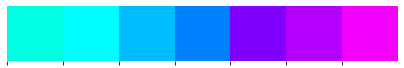

In [ ]:
import pandas as pd
import numpy as np
import gc
from sklearn.metrics import roc_auc_score
from collections import defaultdict
from tqdm.notebook import tqdm
import lightgbm as lgb
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from tabulate import tabulate
import missingno as msno 
from IPython.display import display_html
from PIL import Image
import gc
import cv2
from scipy.stats import pearsonr
import tqdm
import seaborn as sns

from skimage.transform import resize
import copy
import re

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

# Color Palette
custom_colors = ['#00FFE2', '#00FDFF', '#00BCFF', '#0082FF', '#8000FF', '#B300FF', '#F400FF']
sns.palplot(sns.color_palette(custom_colors))

# Set Style
sns.set_style("whitegrid")
sns.despine(left=True, bottom=True)

# Set tick size
plt.rc('xtick',labelsize=12)
plt.rc('ytick',labelsize=12)

In [ ]:
!python --version

Python 3.6.12


In [ ]:
!lsb_release -a

No LSB modules are available.
Distributor ID:	Ubuntu
Description:	Ubuntu 18.04.5 LTS
Release:	18.04
Codename:	bionic


In [ ]:
# Check CUDA/cuDNN Version
!nvcc -V && which nvcc
!nvidia-smi

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2019 NVIDIA Corporation
Built on Sun_Jul_28_19:07:16_PDT_2019
Cuda compilation tools, release 10.1, V10.1.243
/usr/local/cuda/bin/nvcc
Wed Dec  9 21:08:14 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.45.01    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   43C    P8     9W /  70W |      0MiB / 15079MiB |      0%      Default |
|                               |                      |

In [ ]:
!git clone https://github.com/rapidsai/rapidsai-csp-utils.git
!bash rapidsai-csp-utils/colab/rapids-colab.sh stable

import sys, os

dist_package_index = sys.path.index('/usr/local/lib/python3.6/dist-packages')
sys.path = sys.path[:dist_package_index] + ['/usr/local/lib/python3.6/site-packages'] + sys.path[dist_package_index:]
sys.path
exec(open('rapidsai-csp-utils/colab/update_modules.py').read(), globals())

fatal: destination path 'rapidsai-csp-utils' already exists and is not an empty directory.
PLEASE READ
********************************************************************************************************
Changes:
1. IMPORTANT CHANGES: RAPIDS on Colab will be pegged to 0.14 Stable until further notice.
2. Default stable version is now 0.14.  Nightly will redirect to 0.14.
3. You can now declare your RAPIDSAI version as a CLI option and skip the user prompts (ex: '0.14' or '0.15', between 0.13 to 0.14, without the quotes): 
        "!bash rapidsai-csp-utils/colab/rapids-colab.sh <version/label>"
        Examples: '!bash rapidsai-csp-utils/colab/rapids-colab.sh 0.14', or '!bash rapidsai-csp-utils/colab/rapids-colab.sh stable', or '!bash rapidsai-csp-utils/colab/rapids-colab.sh s'
                  '!bash rapidsai-csp-utils/colab/rapids-colab.sh 0.15, or '!bash rapidsai-csp-utils/colab/rapids-colab.sh nightly', or '!bash rapidsai-csp-utils/colab/rapids-colab.sh n'
Enjoy using RAPIDS!  

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving kaggle.json to kaggle (2).json


In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle competitions download -c riiid-test-answer-prediction

__init__.py: Skipping, found more recently modified local copy (use --force to force download)
competition.cpython-37m-x86_64-linux-gnu.so: Skipping, found more recently modified local copy (use --force to force download)
example_sample_submission.csv: Skipping, found more recently modified local copy (use --force to force download)
100% 1.29G/1.29G [00:06<00:00, 202MB/s]
100% 1.29G/1.29G [00:06<00:00, 223MB/s]
example_test.csv: Skipping, found more recently modified local copy (use --force to force download)
lectures.csv: Skipping, found more recently modified local copy (use --force to force download)
questions.csv: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
!unzip train.csv.zip
!rm train.csv.zip

Archive:  train.csv.zip
replace train.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n


In [ ]:
!pip install GPUtil

import torch
from GPUtil import showUtilization as gpu_usage
from numba import cuda

def free_gpu_cache():
    print("Initial GPU Usage")
    gpu_usage()                             
    torch.cuda.empty_cache()
    cuda.select_device(0)
    cuda.close()
    cuda.select_device(0)
    print("GPU Usage after emptying the cache")
    gpu_usage()

free_gpu_cache()

Initial GPU Usage
| ID | GPU | MEM |
------------------
|  0 |  0% |  0% |
GPU Usage after emptying the cache
| ID | GPU | MEM |
------------------
|  0 |  4% |  1% |


In [ ]:
train = dask_cudf.from_cudf(cudf.read_csv('train.csv',
                          dtype={'row_id': 'int64',
                          'timestamp': 'int64',
                          'user_id': 'int32',
                          'content_id': 'int16',
                          'content_type_id': 'int8',
                          'task_container_id': 'int16',
                          'user_answer': 'int8',
                          'answered_correctly':'int8',
                          'prior_question_elapsed_time': 'float32',
                          'prior_question_had_explanation': 'boolean'}
                   ),npartitions=6).compute()
print(train.shape)

(101230332, 10)




---

# Data Exploration 

---



In [ ]:
print(train.head())
print(train.isnull().sum())
cols = train.columns
for col in cols: 
    print('Unique values :',{col,train[col].nunique()})

train.describe().T

"""print(lectures.head())
print(lectures.isnull().sum())
print(lectures.info())
cols = lectures.columns
for col in cols: 
    print('Unique values in :',{col,lectures[col].nunique()})

lectures.describe().T

print(questions.head())
print(questions.isnull().sum())
print(questions.info())
cols = questions.columns
for col in cols: 
    print('Unique values in :',{col,questions[col].nunique()})

questions.describe().T"""

   row_id  timestamp  ...  prior_question_elapsed_time  prior_question_had_explanation
0       0          0  ...                         null                            null
1       1      56943  ...                      37000.0                           False
2       2     118363  ...                      55000.0                           False
3       3     131167  ...                      19000.0                           False
4       4     137965  ...                      11000.0                           False

[5 rows x 10 columns]
row_id                                  0
timestamp                               0
user_id                                 0
content_id                              0
content_type_id                         0
task_container_id                       0
user_answer                             0
answered_correctly                      0
prior_question_elapsed_time       2351538
prior_question_had_explanation     392506
dtype: int64
Unique values : {10123

"print(lectures.head())\nprint(lectures.isnull().sum())\nprint(lectures.info())\ncols = lectures.columns\nfor col in cols: \n    print('Unique values in :',{col,lectures[col].nunique()})\n\nlectures.describe().T\n\nprint(questions.head())\nprint(questions.isnull().sum())\nprint(questions.info())\ncols = questions.columns\nfor col in cols: \n    print('Unique values in :',{col,questions[col].nunique()})\n\nquestions.describe().T"



---

# Data Analysis

---



In [ ]:
# Data Information
print("Rows: {:,}".format(len(train)), "\n" +
      "Columns: {}".format(len(train.columns)))

# Find Missing Data if any
total = len(train)

# Fill in missing values with "-1"
train["prior_question_elapsed_time"] = train["prior_question_elapsed_time"].fillna(-1)
train["prior_question_had_explanation"] = train["prior_question_had_explanation"].fillna(0)

train.head()

Rows: 99,271,300 
Columns: 10


,row_id,timestamp,user_id,content_id,content_type_id,task_container_id,user_answer,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation
0,0,0,115,5692,0,1,3,1,-1.0,True
1,46,0,124,7900,0,0,0,1,-1.0,True
2,76,0,2746,5273,0,0,1,0,-1.0,True
3,96,0,5382,5000,0,0,0,1,-1.0,True
4,224,0,8623,3915,0,0,3,1,-1.0,True


In [ ]:
def distplot_features(df, feature, title, color = custom_colors[4], categorical=True):
    '''Takes a column from the GPU dataframe and plots the distribution (after count).'''
    
    if categorical:
        values = cupy.asnumpy(df[feature].value_counts().values)
    else:
        values = cupy.asnumpy(df[feature].values)
        
    print('Mean: {:,}'.format(np.mean(values)), "\n"
          'Median: {:,}'.format(np.median(values)), "\n"
          'Max: {:,}'.format(np.max(values)))

    
    plt.figure(figsize = (18, 3))
    
    if categorical:
        sns.distplot(values, hist=False, color = color, kde_kws = {'lw':3})
    else:
        # To speed up the process
        sns.distplot(values[::250000], hist=False, color = color, kde_kws = {'lw':3})
    
    plt.title(title, fontsize=15)
    plt.show();
    
    del values
    gc.collect()

In [ ]:
def barplot_features(df, feature, title, palette = custom_colors[2:]):
    '''Takes the numerical columns (with less than 10 categories) and plots the barplot.'''
    
    # We need to extract both the name of the category and the no. of appearences
    index = cupy.asnumpy(df[feature].value_counts().reset_index()["index"].values)
    values = cupy.asnumpy(df[feature].value_counts().reset_index()[feature].values) 

    plt.figure(figsize = (18, 3))
    sns.barplot(x = index, y = values, palette = custom_colors[2:])
    plt.title(title, fontsize=15)
    plt.show();
    
    del index, values
    gc.collect()

Mean: 7,703,643,654.326523 
Median: 2,674,233,764.5 
Max: 87,425,772,049


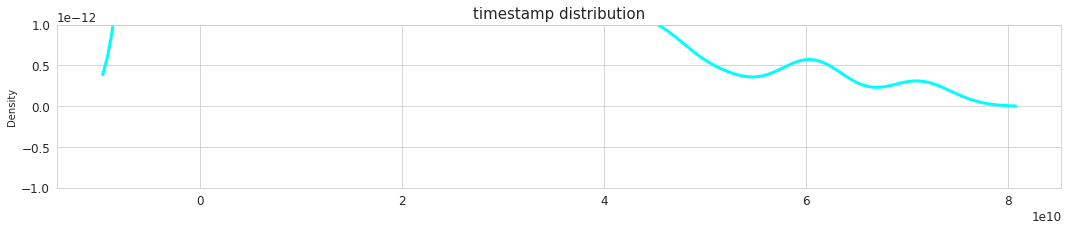

Mean: 24,833.234375 
Median: 21,000.0 
Max: 300,000.0


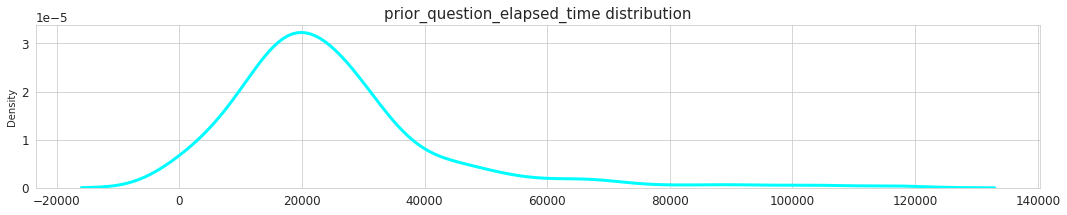

In [ ]:
numerical_features = ['timestamp', 'prior_question_elapsed_time']

for feature in numerical_features:
    distplot_features(train, feature=feature, title = feature + " distribution", color = custom_colors[1], categorical=False)

Mean: 257.1542971528441 
Median: 41.0 
Max: 17,917


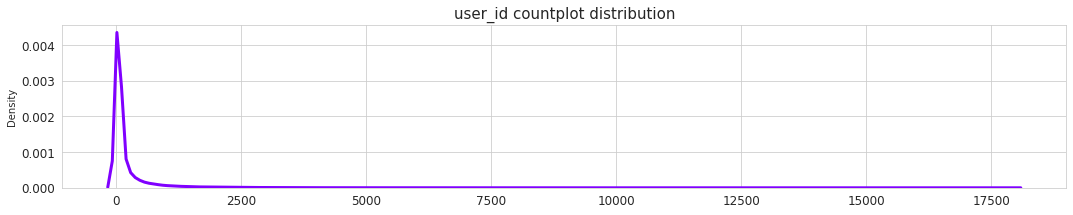

Mean: 7,345.111885067479 
Median: 4,728.5 
Max: 213,605


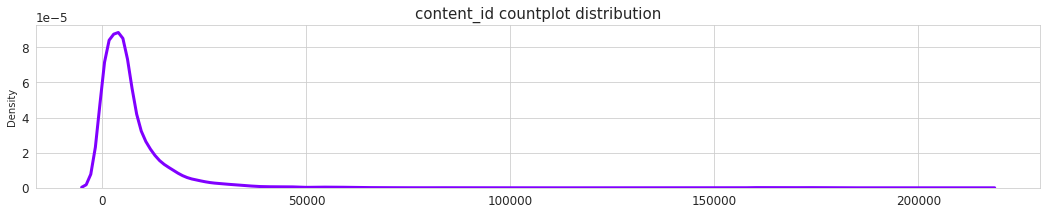

Mean: 10,123.0332 
Median: 1,318.0 
Max: 804,285


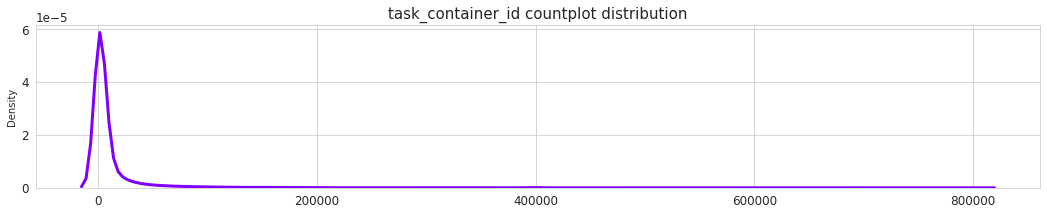

In [ ]:
categorical_features = ['user_id', 'content_id', 'task_container_id']

for feature in categorical_features:
    distplot_features(train, feature=feature, title = feature + " countplot distribution", color = custom_colors[4], categorical=True)

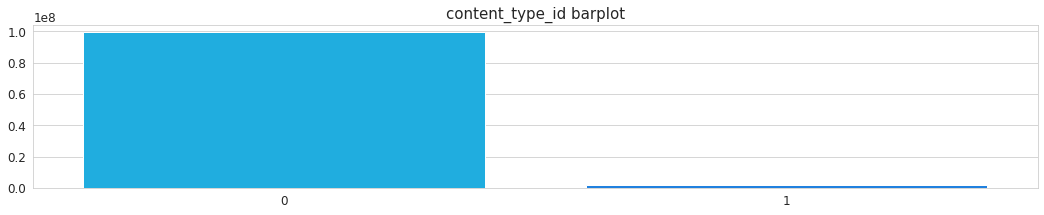

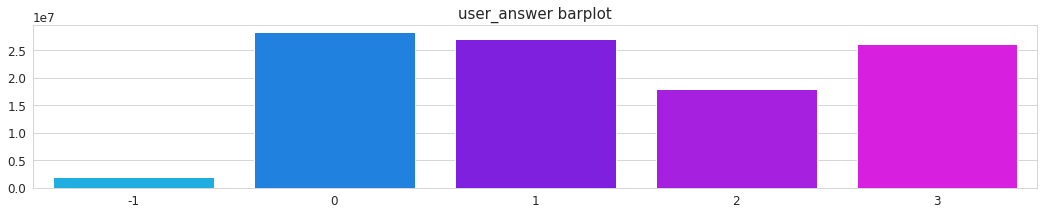

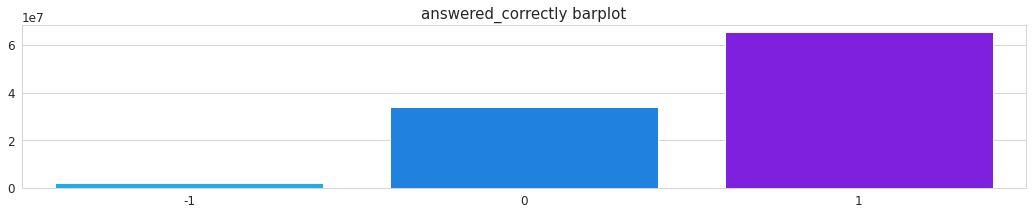

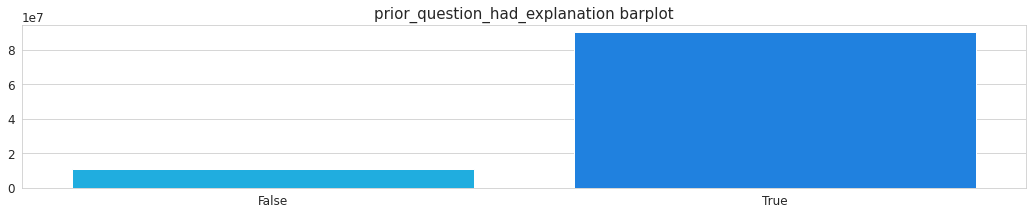

In [ ]:
categorical_for_bar = ['content_type_id', 'user_answer', 
                       'answered_correctly', 'prior_question_had_explanation']

for feature in categorical_for_bar:
    barplot_features(train, feature=feature, title = feature + " barplot")

In [ ]:
questions = cudf.read_csv('questions.csv')

# Data Information
print("Rows: {:,}".format(len(questions)), "\n" +
      "Columns: {}".format(len(questions.columns)))

# Find Missing Data if any
total = len(questions)

for column in questions.columns:
    if questions[column].isna().sum() != 0:
        print("{} has: {:,} ({:.2}%) missing values.".format(column, questions[column].isna().sum(), 
                                                             (questions[column].isna().sum()/total)*100))
        
        
# Fill in missing values with "-1"
questions["tags"] = questions["tags"].fillna(-1)

questions.head()

Rows: 13,523 
Columns: 5
tags has: 1 (0.0074%) missing values.


,question_id,bundle_id,correct_answer,part,tags
0,0,0,0,1,51 131 162 38
1,1,1,1,1,131 36 81
2,2,2,0,1,131 101 162 92
3,3,3,0,1,131 149 162 29
4,4,4,3,1,131 5 162 38


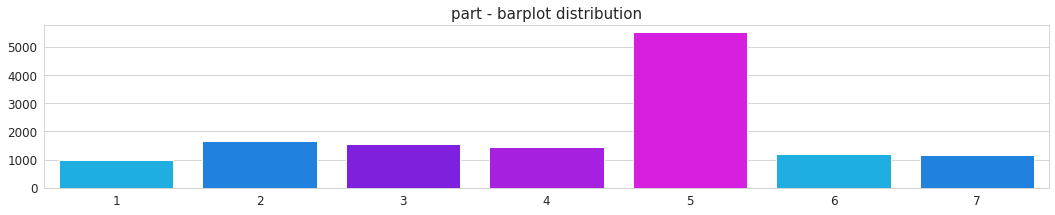

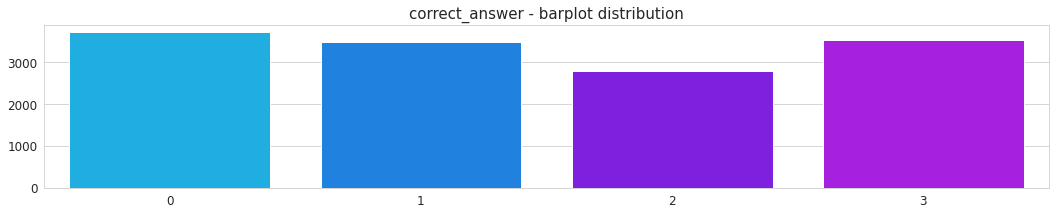

In [ ]:
for feature in ['part', 'correct_answer']:
    barplot_features(questions, feature=feature, title=feature + " - barplot distribution")

Mean: 8.89671052631579 
Median: 2.0 
Max: 738


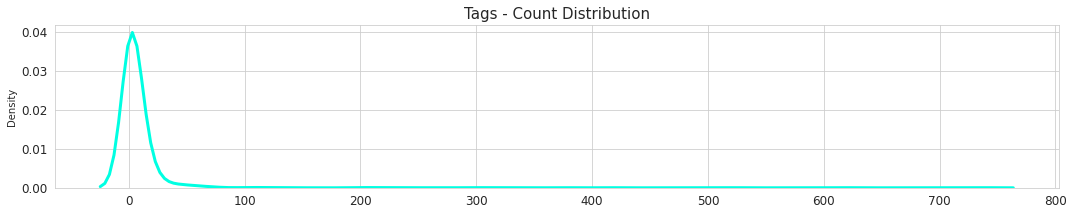

In [ ]:
distplot_features(questions, 'tags', title = "Tags - Count Distribution", color = custom_colors[0], categorical=True)



---

# Data Preprocessing

---



In [ ]:
free_gpu_cache()

Initial GPU Usage
| ID | GPU | MEM |
------------------
|  0 |  0% | 67% |
GPU Usage after emptying the cache
| ID | GPU  | MEM |
-------------------
|  0 | 100% |  1% |


In [ ]:
#choosing important attributes
train = dask_cudf.from_cudf(cudf.read_csv('train.csv',
                          dtype={'row_id': 'int64',
                          'timestamp': 'int64',
                          'user_id': 'int32',
                          'content_id': 'int16',
                          'content_type_id': 'int8',
                          'task_container_id': 'int16',
                          'user_answer': 'int8',
                          'answered_correctly':'int8',
                          'prior_question_elapsed_time': 'float32',
                          'prior_question_had_explanation': 'boolean'}
                   ),npartitions=6).compute()
print(train.shape)

In [ ]:
train_grouped = train.groupby('user_id')
train_grouped.nth(5)

,row_id,timestamp,content_id,content_type_id,task_container_id,user_answer,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation
user_id,,,,,,,,,
115,5,157063,156,0,5,2,1,5000.0,False
124,51,189483,2063,0,4,3,0,18000.0,False
2746,81,111621,382,0,5,0,1,16000.0,False
5382,101,178049,4990,0,5,3,1,12000.0,False
8623,229,189115,5738,0,5,2,1,35000.0,False
...,...,...,...,...,...,...,...,...,...
2147470770,101228994,149366,2065,0,4,2,1,16000.0,False
2147470777,101229222,19189567,2064,0,4,0,0,17000.0,False
2147481750,101229980,93397,378,0,5,1,1,15000.0,False


In [ ]:
"""df1 = cudf.DataFrame([['a', 1], ['b', 2], ['c', 1], ['a', 2],['a', 1], ['b', 2], ['c', 1], ['a', 2],['a', 1], ['b', 2], ['c', 1], ['a', 2],['a', 1], ['b', 2], ['c', 1], ['a', 2],['a', 1], ['b', 2], ['c', 1], ['a', 2]],
                  columns=['A', 'B'])

data = df1.to_pandas()
print(data.groupby('A').tail(5))"""

In [ ]:
#split based on user_id and timestamp
train = train[train.content_type_id == False].sort_values('timestamp').reset_index(drop = True)
print(train.shape)
train_pd = train.to_pandas()
valid_split = train_pd.groupby('user_id').tail(5)
del(train_pd)
valid_split1 = cudf.from_pandas(valid_split)
del(valid_split)
train_split1 = train[~train.row_id.isin(valid_split1.row_id)]

In [ ]:
del(train_split1)
del(valid_split1)

In [ ]:
"""import random
max_timestamp_u = train[['user_id','timestamp']].groupby(['user_id']).agg(['max']).reset_index()
max_timestamp_u.columns = ['user_id', 'max_time_stamp']
MAX_TIME_STAMP = max_timestamp_u.max_time_stamp.max()
def rand_time(max_time_stamp):
    interval = MAX_TIME_STAMP - max_time_stamp
    rand_time_stamp = random.randint(0,interval)
    return rand_time_stamp

max_timestamp_u_pd = max_timestamp_u.to_pandas()
max_timestamp_u['rand_time_stamp'] = max_timestamp_u_pd.max_time_stamp.apply(rand_time)
del(max_timestamp_u_pd)
train = train.merge(max_timestamp_u, on='user_id', how='left')
del(max_timestamp_u)
train['viretual_time_stamp'] = train.timestamp + train['rand_time_stamp']
train = train.sort_values(['viretual_time_stamp', 'row_id']).reset_index(drop=True)"""

In [ ]:
#split training and testing set
#created 5 cross validation sets
val_size = 2500000

for cv in range(5):
    valid = train[-val_size:]
    train = train[:-val_size]
    # check new users and new contents
    new_users = len(valid[~valid.user_id.isin(train.user_id)].user_id.unique())
    valid_question = valid[valid.content_type_id == 0]
    train_question = train[train.content_type_id == 0]
    new_contents = len(valid_question[~valid_question.content_id.isin(train_question.content_id)].content_id.unique())    
    print('cv{cv} {train_question.answered_correctly.mean():.3f} {valid_question.answered_correctly.mean():.3f} {new_users} {new_contents}')
    valid.to_pickle(f'cv{cv+1}_valid.pickle')
    train.to_pickle(f'cv{cv+1}_train.pickle')

Feature Engineering

In [ ]:
"""from google.colab import drive
drive.mount('/content/drive')"""

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
"""train_pickle ='drive/My Drive/Colab Data/riiid/cv1_train.pickle'
valid_pickle = 'drive/My Drive/Colab Data/riiid/cv1_valid.pickle'
question_file = 'drive/My Drive/Colab Data/riiid/questions.csv'"""

In [ ]:
#add new features - answered_correctly count,sum,average
def add_user_feats(df, answered_correctly_sum_u_dict, count_u_dict):
    acsu = np.zeros(len(df), dtype=np.int32)
    cu = np.zeros(len(df), dtype=np.int32)
    for cnt,row in enumerate(tqdm(df[['user_id','answered_correctly']].values)):
        acsu[cnt] = answered_correctly_sum_u_dict[row[0]]
        cu[cnt] = count_u_dict[row[0]]
        answered_correctly_sum_u_dict[row[0]] += row[1]
        count_u_dict[row[0]] += 1
    user_feats_df = pd.DataFrame({'answered_correctly_sum_u':acsu, 'count_u':cu})
    user_feats_df['answered_correctly_avg_u'] = user_feats_df['answered_correctly_sum_u'] / user_feats_df['count_u']
    df = pd.concat([df, user_feats_df], axis=1)
    del(user_feats_df)
    del(acsu,cu)
    return df

In [ ]:
field_needed = ['row_id', 'user_id', 'content_id', 'content_type_id', 'answered_correctly', 'prior_question_elapsed_time', 'prior_question_had_explanation']

answered_correctly_sum_u_dict = defaultdict(int)
count_u_dict = defaultdict(int)

train = pd.read_pickle(train_pickle)[field_needed]
train = train.loc[train.content_type_id == False].reset_index(drop=True)
train = add_user_feats(train, answered_correctly_sum_u_dict, count_u_dict)

valid = pd.read_pickle(valid_pickle)[field_needed]
valid = valid.loc[valid.content_type_id == False].reset_index(drop=True)
valid = add_user_feats(valid, answered_correctly_sum_u_dict, count_u_dict) 

del(answered_correctly_sum_u_dict)
del(count_u_dict)


In [ ]:
#merging train wiht new features
#extra attribute for answered correctly based on content_id
content_df = train[['content_id','answered_correctly']].groupby(['content_id']).agg(['mean']).reset_index()
print(content_df)
content_df.columns = ['content_id', 'answered_correctly_avg_c']

train = cudf.merge(train, content_df, on=['content_id'], how="left")
valid = cudf.merge(valid, content_df, on=['content_id'], how="left")

print(train.shape)
print(valid.shape)

del(content_df)

      content_id answered_correctly
                               mean
0              0           0.907334
1              1           0.890571
2              2           0.554213
3              3           0.779386
4              4           0.613970
...          ...                ...
13518      13518           0.782936
13519      13519           0.564912
13520      13520           0.674129
13521      13521           0.804483
13522      13522           0.909887

[13523 rows x 2 columns]


In [ ]:
#fill NA with mean
prior_question_elapsed_time_mean=train["prior_question_elapsed_time"].mean(skipna=True)
train["prior_question_elapsed_time"].fillna(prior_question_elapsed_time_mean, inplace=True)

train['prior_question_elapsed_time_mean'] = train.prior_question_elapsed_time.fillna(prior_question_elapsed_time_mean)
valid['prior_question_elapsed_time_mean'] = valid.prior_question_elapsed_time.fillna(prior_question_elapsed_time_mean)

train1 = cudf.from_pandas(train)
valid1 = cudf.from_pandas(valid)

del(train,valid)

#merge train with questions.csv
questions_df = cudf.read_csv(question_file)
train1 = cudf.merge(train1, questions_df[['question_id', 'part']], left_on = 'content_id', right_on = 'question_id', how = 'left')
valid1 = cudf.merge(valid1, questions_df[['question_id', 'part']], left_on = 'content_id', right_on = 'question_id', how = 'left')

train1['prior_question_had_explanation'] = train1.prior_question_had_explanation.fillna(False).astype('int8')
valid1['prior_question_had_explanation'] = valid1.prior_question_had_explanation.fillna(False).astype('int8')

del(questions_df)

In [ ]:
import pickle
"""train = train.to_pandas()
valid = valid.to_pandas()"""

"""pickle.dump(valid1, open( "cu_lgb_valid.p", "wb" ) )
pickle.dump(train1, open( "cu_lgb_train.p", "wb" ) )"""

Modeliing


# Model

## LightGBM

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!git clone --recursive https://github.com/microsoft/LightGBM 
!cd LightGBM && rm -rf build && mkdir build && cd build && cmake -DUSE_GPU=1 ../../LightGBM && make -j4 && cd ../python-package && python3 setup.py install --precompile --gpu;

fatal: destination path 'LightGBM' already exists and is not an empty directory.
-- The C compiler identification is GNU 7.5.0
-- The CXX compiler identification is GNU 7.5.0
-- Check for working C compiler: /usr/bin/cc
-- Check for working C compiler: /usr/bin/cc -- works
-- Detecting C compiler ABI info
-- Detecting C compiler ABI info - done
-- Detecting C compile features
-- Detecting C compile features - done
-- Check for working CXX compiler: /usr/bin/c++
-- Check for working CXX compiler: /usr/bin/c++ -- works
-- Detecting CXX compiler ABI info
-- Detecting CXX compiler ABI info - done
-- Detecting CXX compile features
-- Detecting CXX compile features - done
-- Found OpenMP_C: -fopenmp (found version "4.5") 
-- Found OpenMP_CXX: -fopenmp (found version "4.5") 
-- Found OpenMP: TRUE (found version "4.5")  
-- Looking for CL_VERSION_2_2
-- Looking for CL_VERSION_2_2 - found
-- Found OpenCL: /usr/lib/x86_64-linux-gnu/libOpenCL.so (found version "2.2") 
-- OpenCL include directory:

In [ ]:
import pandas as pd

train_pickle ='/content/drive/My Drive/Colab Data/riiid/lgb_train.p'
valid_pickle = '/content/drive/My Drive/Colab Data/riiid/lgb_valid.p'

train = pd.read_pickle(train_pickle)
valid = pd.read_pickle(valid_pickle)

In [ ]:
import lightgbm as lgb
from sklearn.metrics import roc_auc_score
 
FEATS = ['row_id', 'user_id', 'content_id', 'content_type_id',
       'prior_question_elapsed_time',
       'prior_question_had_explanation', 'answered_correctly_sum_u', 'count_u',
       'answered_correctly_avg_u', 'answered_correctly_avg_c',
       'prior_question_elapsed_time_mean', 'question_id', 'part']
 
TARGET = ['answered_correctly']
 
"""X_train = train[FEATS]
y_train = train[TARGET]
X_valid = valid[FEATS]
y_valid = valid[TARGET]
"""

lgb_train = lgb.Dataset(train[FEATS],label = train[TARGET])
lgb_valid = lgb.Dataset(valid[FEATS],label = valid[TARGET])

categorical = [col for col in train[FEATS].columns if train[FEATS][col].dtype == 'object']


In [ ]:
"""from scipy.stats import randint as sp_randint
from scipy.stats import uniform as sp_uniform
param_test ={'num_leaves': sp_randint(6, 50), 
             'min_child_samples': sp_randint(100, 500), 
             'min_child_weight': [1e-5, 1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3, 1e4],
             'subsample': sp_uniform(loc=0.2, scale=0.8), 
             'colsample_bytree': sp_uniform(loc=0.4, scale=0.6),
             'reg_alpha': [0, 1e-1, 1, 2, 5, 7, 10, 50, 100],
             'reg_lambda': [0, 1e-1, 1, 5, 10, 20, 50, 100]}

X_valid = valid[FEATS]
y_valid = valid[TARGET]

fit_params={"early_stopping_rounds":30, 
            "eval_metric" : 'auc', 
            "eval_set" : [(X_valid,y_valid)],
            'eval_names': ['valid'],
            #'callbacks': [lgb.reset_parameter(learning_rate=learning_rate_010_decay_power_099)],
            'verbose': 100,
            'categorical_feature': 'auto'}

#This parameter defines the number of HP points to be tested
n_HP_points_to_test = 100

import lightgbm as lgb
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

#n_estimators is set to a "large value". The actual number of trees build will depend on early stopping and 5000 define only the absolute maximum
clf = lgb.LGBMClassifier(max_depth=-1, random_state=314, silent=True, metric='None', n_jobs=4, n_estimators=5000)
gs = RandomizedSearchCV(
    estimator=clf, param_distributions=param_test, 
    n_iter=n_HP_points_to_test,
    scoring='roc_auc',
    cv=3,
    refit=True,
    random_state=314,
    verbose=True)

gs.fit(X_train, y_train, **fit_params)
print('Best score reached: {} with params: {} '.format(gs.best_score_, gs.best_params_))"""

Training until validation scores don't improve for 50 rounds
[50]	training's auc: 0.754364	valid_1's auc: 0.761908
[100]	training's auc: 0.757409	valid_1's auc: 0.762971
[150]	training's auc: 0.759648	valid_1's auc: 0.763346
[200]	training's auc: 0.761556	valid_1's auc: 0.763547
[250]	training's auc: 0.763154	valid_1's auc: 0.763586
[300]	training's auc: 0.76452	valid_1's auc: 0.76355
Early stopping, best iteration is:
[254]	training's auc: 0.763247	valid_1's auc: 0.763592
auc_valid: 0.763592025279911


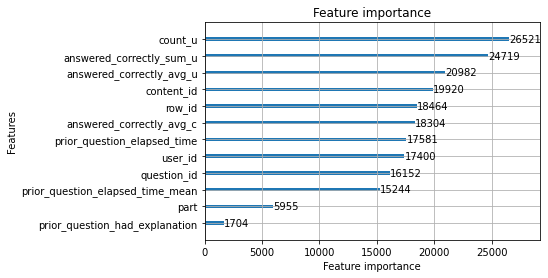

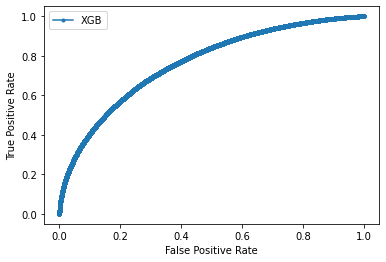

CPU times: user 27min 50s, sys: 12.4 s, total: 28min 2s
Wall time: 15min 8s


In [ ]:
%%time

model = lgb.train(
                    {
                        'objective': 'binary',
                        'boosting_type': 'gbdt',
                        'metric': ['auc'],
                        'learning_rate': 0.05,
                        'max_bin': 200,
                        'device_type':'gpu',
                        'num_leaves': 800,
                        'feature_fraction': 0.6,
                        'bagging_fraction': 0.8,
                        'bagging_freq': 5,
                        'verbose' : 0
                    }, 
                    lgb_train,
                    valid_sets=[lgb_train, lgb_valid],
                    verbose_eval=50,
                    num_boost_round=5000,
                    early_stopping_rounds=50
                )

print( 'auc_valid:', roc_auc_score(valid[TARGET], model.predict(valid[FEATS])))

lgb.plot_importance(model)
plt.show()

from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt

lr_fpr, lr_tpr, _ = roc_curve(valid[TARGET], model.predict(valid[FEATS]))
plt.plot(lr_fpr, lr_tpr, marker='.', label='XGB')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

## -


ROC for XGBoost model
0.7618490744824115


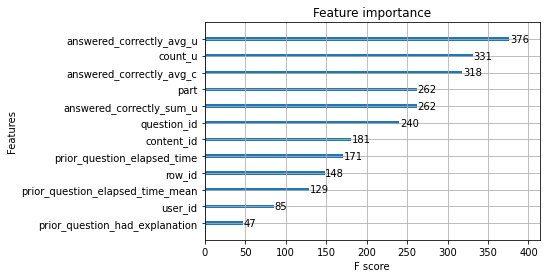

In [ ]:
"""%%time

import xgboost
from xgboost import XGBClassifier
from xgboost import plot_importance

from xgboost import XGBClassifier
# Creating the model
model_XGB = XGBClassifier()

# Training the model
model_XGB.fit(train[FEATS], train[TARGET])

# predict probabilities
XGB_probs = model_XGB.predict_proba(train[FEATS])

# keep probabilities for the positive outcome only
XGB_probs = XGB_probs[:, 1]

# calculate scores
XGB_auc = roc_auc_score(train[TARGET], XGB_probs)

# result print
print('XGBoost: ROC AUC = %.3f' % (XGB_auc * 100))

params1 = {
    'max_depth' : 7,
   # 'max_leaves' : 2**4,
    'alpha':0.1, 
   # 'lambda' : 0.17,
    'min_child_weight ':2,
    'subsample':0.7,
    'tree_method' : 'gpu_hist',
    'learning_rate': 0.1, #default = 0.3,
    'colsample_bytree':0.7,
    'eval_metric':'auc', 
    'objective' : 'binary:logistic',
    'grow_policy' : 'lossguide',
    'n_estimators':200
}

train_matrix = xgboost.DMatrix(data = train[FEATS], label =  train[TARGET])
test_matrix=xgboost.DMatrix(data = valid[FEATS])
xgb = xgboost.train(params1, dtrain = train_matrix)

predicts = xgb.predict(test_matrix)
roc = roc_auc_score(valid[TARGET].astype('int32'), predicts)
print('ROC for XGBoost model')
print(roc)

plot_importance(xgb)"""

from sklearn.metrics import roc_auc_score
 
FEATS = ['row_id', 'user_id', 'content_id', 'content_type_id',
       'prior_question_elapsed_time',
       'prior_question_had_explanation', 'answered_correctly_sum_u', 'count_u',
       'answered_correctly_avg_u', 'answered_correctly_avg_c',
       'prior_question_elapsed_time_mean', 'question_id', 'part']
 
TARGET = ['answered_correctly']
 
X_train = train[FEATS]
y_train = train[TARGET]
X_valid = valid[FEATS]
y_valid = valid[TARGET]


import xgboost
from xgboost import XGBClassifier
from xgboost import plot_importance

params = {
    'max_depth' : 12,
    'max_leaves' : 2**8,
    'eta':0.6,  # Step size shrinkage used in update to prevents overfitting
                # After each boosting step, we can directly get the weights of 
    # new features, and eta shrinks the feature weights to make the boosting 
    # process more conservative.
    'alpha':0.1,     # L1 regularization term on weights. 
    'lambda' : 0.2,  # L2 regularization term on weights. 
                     # Increasing this value will make model more conservative.
    'min_child_weight':1,
    'subsample':0.8,  # default = 1, Subsample ratio of the training instances. 
                      # Setting it to 0.5 means that XGBoost would randomly 
                      # sample half of the training data prior to growing trees.
                      # l prevent overfitting. 
                      # Subsampling will occur once in every boosting iteration.
    'tree_method' : 'gpu_hist',
    'learning_rate': 0.5, #default = 0.3,
    'colsample_bytree':0.7, # is the subsample ratio of columns when constructing each tree. 
                            # Subsampling occurs once for every tree constructed.
    'eval_metric':'auc', 
    'objective' : 'binary:logistic',
    'sample_type': 'weighted',
    'grow_policy' : 'lossguide',
    'n_estimators': 200,
    'normalize_type': 'tree',
    'rate_drop': 0.2,    # dropout rate 
    'skip_drop': 0.1,    # probability of skipping dropout (If a dropout is 
                         # skipped, new trees are added in the same manner as gbtree.)
    'feature_selector':'thrifty',  # This operation is multithreaded and is a 
    # linear complexity approximation of the quadratic greedy selection. 
    'deterministic_histogram': 'true',  # Histogram building is not deterministic 
    # due to the non-associative aspect of floating point summation. We employ a 
    # pre-rounding routine to mitigate the issue, which may lead to slightly lower 
    # accuracy
    # 'booster' : 'dart'
    'single_precision_histogram':'true', # single precision to build histograms instead of double precision
    'sampling_method':'gradient_based', # only supported when tree_method is set to gpu_hist    
    'predictor': 'gpu_predictor'

}

num_round = 50
train_matrix = xgboost.DMatrix(data = train[FEATS], label =  train[TARGET])
test_matrix = xgboost.DMatrix(data = valid[FEATS])
xgb = xgboost.train(params, dtrain = train_matrix)

predicts = xgb.predict(test_matrix, ntree_limit=num_round)
roc = roc_auc_score(valid[TARGET].astype('int32'), predicts)
print('ROC for XGBoost model')
print(roc)
plot_importance(xgb)